# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


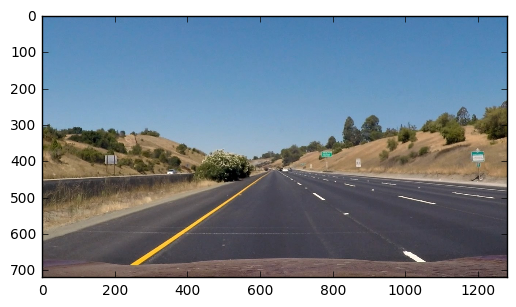

In [3]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    plt.imshow(masked_image)
    plt.show()
    return masked_image

glb_slope_left = glb_slope_right = glb_intercept_left = glb_intercept_right = 0.0

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    global glb_slope_left 
    global glb_slope_right
    global glb_intercept_left 
    global glb_intercept_right
    imshape = img.shape
    left_lane = []
    left_slope = []
    right_lane = []
    right_slope = []
    left_intercept = []
    right_intercept = []
    line_length_left = []
    line_length_right = []
    thickness = 10
    new_lines = []
    if(lines== None):
        mean_left_intercept = glb_intercept_left 
        mean_left_slope =glb_slope_left 
        mean_right_intercept = glb_intercept_right 
        mean_right_slope = glb_slope_right 

        im2 = np.copy(img) 
        #lanes
        left_lane = np.array([[[(imshape[0]-mean_left_intercept)/mean_left_slope,imshape[0],
                               ((imshape[0]/2)+80 -mean_left_intercept )/mean_left_slope, imshape[0]/2+80]]],dtype=np.int32)

        right_lane = np.array([[[(imshape[0]-mean_right_intercept)/mean_right_slope, imshape[0],
                               ((imshape[0]/2)+80 -mean_right_intercept )/mean_right_slope, imshape[0]/2+80]]],dtype=np.int32)

        lanes = np.vstack((left_lane,right_lane))
        thickness = 12

        for line in lanes:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        return im2
    l = []    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            slope = (y2-y1)/(x2-x1)
            # filter based on slope and x-coordinates that are in right area
            if  slope <0.0 and slope > -0.9 and slope < -0.5 and x1 < imshape[1]/2 and x2 < imshape[1]/2:
                left_slope.append(slope)
                left_lane.append(line)
                left_intercept.append(y2-slope*x2)
                line_length_left.append((y2-y1)**2+(x2-x1)**2)
            elif slope>0.0 and slope > 0.5 and slope < 0.9 and x1 > imshape[1]/2 and x2 > imshape[1]/2:
                right_lane.append(line)
                right_slope.append(slope)
                right_intercept.append(y2-slope*x2)
                line_length_right.append((y2-y1)**2+(x2-x1)**2)

    if(len(line_length_left) == 0):
        mean_left_slope = glb_slope_left
        mean_left_intercept = glb_intercept_left
    else:
        #pick the slope of the prominent line
        mean_left_slope =left_slope[line_length_left.index(max(line_length_left))]   #np.mean(left_slope)#left_slope[line_length_left.index(max(line_length_left))]  
        mean_left_intercept = left_intercept[line_length_left.index(max(line_length_left))]#np.mean(left_intercept)#[left_slope.index(mean_left_slope)]    

    if(len(line_length_right) == 0):
        mean_right_slope = glb_slope_right
        mean_right_intercept = glb_intercept_right
    else:
        mean_right_slope = right_slope[line_length_right.index(max(line_length_right))]# np.mean(right_slope)#right_slope[line_length_right.index(max(line_length_right))]
        mean_right_intercept = right_intercept[line_length_right.index(max(line_length_right))]#np.mean(right_intercept)#[right_slope.index(mean_right_slope)]
    
    if(glb_slope_left == 0.0):
        glb_slope_left = mean_left_slope
    if(glb_slope_right == 0.0):
        glb_slope_right = mean_right_slope
    
    #pick the intercept of the prominent line
    
    if(glb_intercept_left == 0.0):
        glb_intercept_left = mean_left_intercept
    if(glb_intercept_right == 0.0):
        glb_intercept_right = mean_right_intercept
    
    #running average
    mean_left_intercept = glb_intercept_left * 0.9 + mean_left_intercept *0.1
    mean_right_intercept = glb_intercept_right * 0.9 + mean_right_intercept *0.1
    mean_left_slope = glb_slope_left * 0.9 + mean_left_slope *0.1
    mean_right_slope = glb_slope_right * 0.9 + mean_right_slope *0.1
    
    glb_intercept_left = mean_left_intercept
    glb_slope_left = mean_left_slope
    glb_intercept_right = mean_right_intercept
    glb_slope_right = mean_right_slope
    
    im2 = np.copy(img) 
    
    #lanes
    left_lane = np.array([[[(imshape[0]-mean_left_intercept)/mean_left_slope,imshape[0],
                           ((imshape[0]/2)+80 -mean_left_intercept )/mean_left_slope, imshape[0]/2+80]]],dtype=np.int32)
    
    right_lane = np.array([[[(imshape[0]-mean_right_intercept)/mean_right_slope, imshape[0],
                           ((imshape[0]/2)+80 -mean_right_intercept )/mean_right_slope, imshape[0]/2+80]]],dtype=np.int32)
    
    lanes = np.vstack((left_lane,right_lane))
    thickness = 12
             
    for line in lanes:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    #lines only for debugging purpose
    
    thickness = 1
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(im2, (x1, y1), (x2, y2), color, thickness)
    return im2
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    im = draw_lines(line_img, lines )
    return (line_img,im)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
images = os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

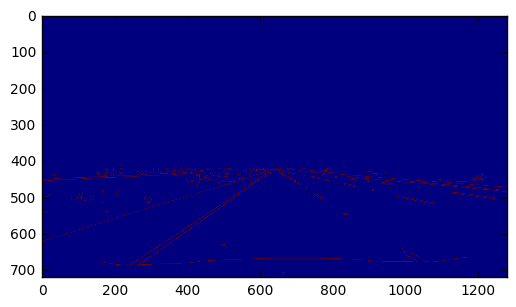

//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:80: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


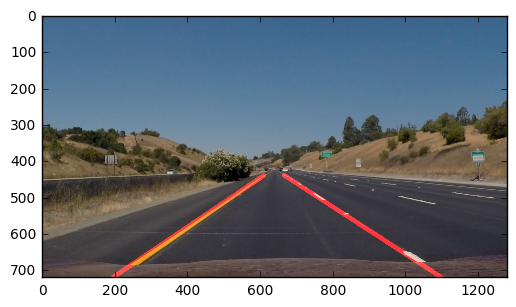

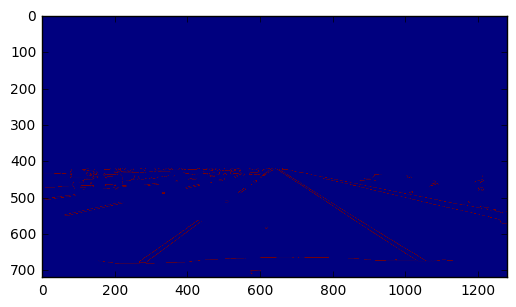

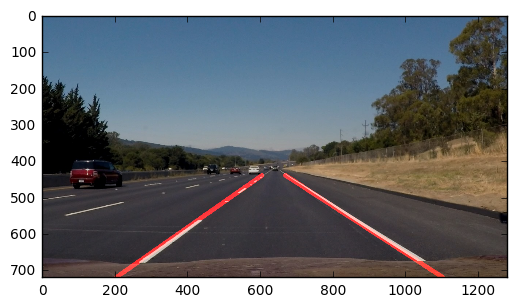

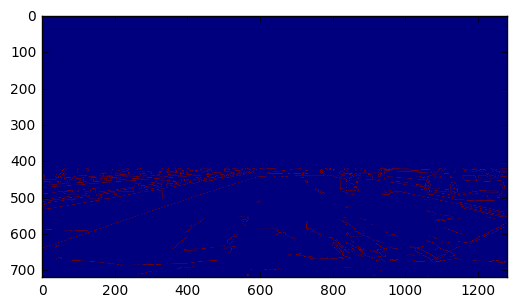

ZeroDivisionError: float division by zero

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
debug = False
import scipy.misc
for image_str in images:
    if(not image_str.startswith("marked")):
        im_path = "test_images/"+image_str
        image = mpimg.imread(im_path)
        glb_slope_left = glb_slope_right = glb_intercept_left = glb_intercept_right = 0.0

        gray_image = gaussian_blur(grayscale(np.copy(image)),7)
        canny_image = canny(gray_image,40,100)
        imshape  = gray_image.shape

        vertices = np.array([[(0,imshape[0]),(0, imshape[0]/2+60), (imshape[1], imshape[0]/2+60), (imshape[1],imshape[0])]], dtype=np.int32)

        masked_image = region_of_interest(canny_image,vertices) 

        rho = 1
        threshold = 50     
        min_line_len = 15
        max_line_gap = 105
        theta = np.pi/180 
        line_image = np.copy(image)*0 

        lines_img,im = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
        wt_image = weighted_img(lines_img,image)
        plt.imshow(wt_image)
        plt.show()
        out_path = "test_images/marked_"+image_str
        scipy.misc.imsave(out_path, wt_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [35]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    hsvimg = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    
    gray_image = gaussian_blur(grayscale(np.copy(image)),9)
    canny_image = canny(gray_image,20,60)
    
    imshape  = gray_image.shape
    
    vertices = np.array([[(0,imshape[0]),(0, imshape[0]/2+60), (imshape[1], imshape[0]/2+60), (imshape[1],imshape[0])]], dtype=np.int32)
    
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 255, 255])
    
    #0, 0, 200
    #180, 255, 255
    # Threshold the HSV image to get only yellow colors
    maskhsv = cv2.inRange(hsvimg, lower_yellow, upper_yellow)
    maskwhite_hsv = cv2.inRange(hsvimg,lower_white,upper_white)

    # Bitwise-AND mask and original image
    res_yellow = cv2.bitwise_and(image,image, mask= maskhsv)
    res_white = cv2.bitwise_and(image,image, mask= maskwhite_hsv)
    res = cv2.bitwise_or(res_yellow,res_white)
    
    gray_image_hsv = gaussian_blur(grayscale(np.copy(res)),9)
    canny_image_hsv = canny(gray_image_hsv,5,15)
    
    masked_hsvimg = region_of_interest(canny_image_hsv,vertices)
    #print( np.shape(masked_hsvimg) )
    
    masked_image = region_of_interest(canny_image,vertices) 
    
    rho = 1
    threshold = 5     
    min_line_len = 15
    max_line_gap = 60
    theta = np.pi/180 
    line_image = np.copy(image)*0 
    
    lines_img,lines_img_hough = hough_lines(masked_hsvimg, rho, theta, threshold, min_line_len, max_line_gap)
    
    
    im_hough = weighted_img(lines_img,image)
    if(debug):
        result1 =weighted_img(lines_img_hough,image) 
        im1 = np.hstack([res,cv2.cvtColor(canny_image_hsv,cv2.COLOR_GRAY2RGB)])
        im2  = np.hstack([result1,im_hough])
        result = np.vstack([im1,im2])
    else:
        result = im_hough
    return result

Let's try the one with the solid white lane on the right first ...

In [36]:
glb_slope_left = glb_slope_right = glb_intercept_left = glb_intercept_right = 0.0
debug = False
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4




  0%|          | 0/222 [00:00<?, ?it/s]

  1%|          | 2/222 [00:00<00:12, 17.61it/s]

  2%|▏         | 4/222 [00:00<00:14, 15.12it/s]

  3%|▎         | 6/222 [00:00<00:14, 15.03it/s]

  4%|▎         | 8/222 [00:00<00:13, 15.61it/s]

  5%|▍         | 10/222 [00:00<00:12, 16.42it/s]

  5%|▌         | 12/222 [00:00<00:13, 15.64it/s]

  6%|▋         | 14/222 [00:00<00:12, 16.42it/s]

  7%|▋         | 16/222 [00:01<00:12, 16.48it/s]

  8%|▊         | 18/222 [00:01<00:12, 16.94it/s]

  9%|▉         | 20/222 [00:01<00:12, 16.46it/s]

 10%|▉         | 22/222 [00:01<00:17, 11.50it/s]

 11%|█         | 24/222 [00:01<00:19, 10.42it/s]

 12%|█▏        | 26/222 [00:01<00:17, 11.32it/s]

 13%|█▎        | 28/222 [00:02<00:15, 12.56it/s]

 14%|█▍        | 31/222 [00:02<00:13, 14.35it/s]

 15%|█▍        | 33/222 [00:02<00:12, 14.66it/s]

 16%|█▌        | 35/222 [00:02<00:13, 13.57it/s]

 17%|█▋        | 37/222 [00:02<00:16, 11.21it/s]

 18%|█▊        | 39/222 [00:02<00:18, 10.09it/s]

 18%|█▊    

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 9.7 s, sys: 1.19 s, total: 10.9 s
Wall time: 20.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [38]:
glb_slope_left = glb_slope_right = glb_intercept_left = glb_intercept_right = 0.0
Debug = False
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4




  0%|          | 0/682 [00:00<?, ?it/s]

  0%|          | 2/682 [00:00<01:22,  8.24it/s]

  1%|          | 4/682 [00:00<01:13,  9.22it/s]

  1%|          | 5/682 [00:00<01:12,  9.34it/s]

  1%|          | 7/682 [00:00<01:06, 10.13it/s]

  1%|▏         | 9/682 [00:00<01:02, 10.83it/s]

  1%|▏         | 10/682 [00:00<01:07,  9.98it/s]

  2%|▏         | 11/682 [00:01<01:11,  9.43it/s]

  2%|▏         | 13/682 [00:01<01:04, 10.30it/s]

  2%|▏         | 15/682 [00:01<00:59, 11.21it/s]

  2%|▏         | 17/682 [00:01<00:58, 11.45it/s]

  3%|▎         | 19/682 [00:01<00:58, 11.37it/s]

  3%|▎         | 21/682 [00:01<00:51, 12.71it/s]

  3%|▎         | 23/682 [00:01<00:54, 12.04it/s]

  4%|▍         | 26/682 [00:02<00:48, 13.58it/s]

  4%|▍         | 29/682 [00:02<00:41, 15.90it/s]

  5%|▍         | 32/682 [00:02<00:36, 17.81it/s]

  5%|▌         | 35/682 [00:02<00:37, 17.08it/s]

  6%|▌         | 38/682 [00:02<00:34, 18.55it/s]

  6%|▌         | 41/682 [00:02<00:32, 19.48it/s]

  6%|▋      

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 26.9 s, sys: 2.56 s, total: 29.5 s
Wall time: 47.9 s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>"
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

## Notes:
The pipeline with stright line is tricky to get right for all situations , as the lane line might be curved. 
One could fit a polynomial curve of degree two on the lane points or splines (initial part as degree one and later pat as degree two polynomial). Current approach takes a moving average (slope and intercepts for left and right lanes) approach on the most prominent line detect within the range of allowed slope value. Other challenges could be  in merge and turns lane detection might not be good. 

Here are the steps that was taken: 
1. RGB to HSV
2. Filter out the Yellow and White values and merge the masks and mask area of interest.
3. Grayscale convertion 
4. Canny edge detection 
5. Hough transformations to find the lines
6. Filter the lines by capping the left and right slopes.
7. Also, filter the lines on the right and left side of the image center ( x axis should not cross the center )
8. find the prominent line ( max length )
9. Moving average of the slope and intercept to find the lane lines.

There is a debug option that can be set to get videos at different state. Here is an example
https://youtu.be/1QRJDIEyfE4

Reference:

[1] https://en.wikipedia.org/wiki/HSL_and_HSV

[2] http://docs.opencv.org/trunk/da/d22/tutorial_py_canny.html

[3] Forum and slack channel.

[4] https://thesai.org/Downloads/Volume2No5/Paper%2012-A%20robust%20multi%20color%20lane%20marking%20detection%20approach%20for%20Indian%20scenario.pdf

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [41]:
glb_slope_left = glb_slope_right = glb_intercept_left = glb_intercept_right = 0.0

debug = False
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4




  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 1/251 [00:00<00:43,  5.69it/s]

  1%|          | 2/251 [00:00<00:46,  5.33it/s]

  1%|          | 3/251 [00:00<00:40,  6.06it/s]

  2%|▏         | 4/251 [00:00<00:38,  6.36it/s]

  2%|▏         | 5/251 [00:00<00:40,  6.09it/s]

  2%|▏         | 6/251 [00:00<00:40,  6.04it/s]

  3%|▎         | 7/251 [00:01<00:41,  5.92it/s]

  3%|▎         | 8/251 [00:01<00:38,  6.38it/s]

  4%|▎         | 9/251 [00:01<00:42,  5.75it/s]

  4%|▍         | 10/251 [00:01<00:41,  5.84it/s]

  4%|▍         | 11/251 [00:01<00:37,  6.48it/s]

  5%|▍         | 12/251 [00:01<00:34,  6.92it/s]

  5%|▌         | 13/251 [00:02<00:34,  6.82it/s]

  6%|▌         | 14/251 [00:02<00:35,  6.70it/s]

  6%|▌         | 15/251 [00:02<00:33,  6.98it/s]

  6%|▋         | 16/251 [00:02<00:30,  7.63it/s]

  7%|▋         | 18/251 [00:02<00:27,  8.37it/s]

  8%|▊         | 19/251 [00:02<00:34,  6.79it/s]

  8%|▊         | 20/251 [00:02<00:33,  6.95it/s]

  8%|▊         |

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 18.8 s, sys: 2.58 s, total: 21.4 s
Wall time: 36.2 s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

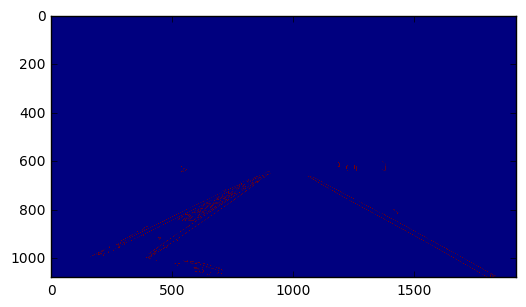

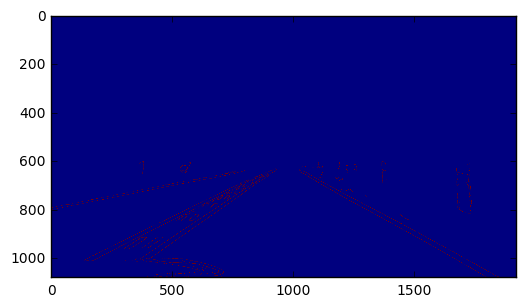

[MoviePy] >>>> Building video ex3.mp4
[MoviePy] Writing video ex3.mp4




  0%|          | 0/721 [00:00<?, ?it/s]

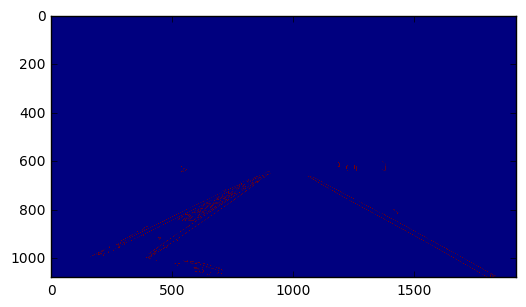

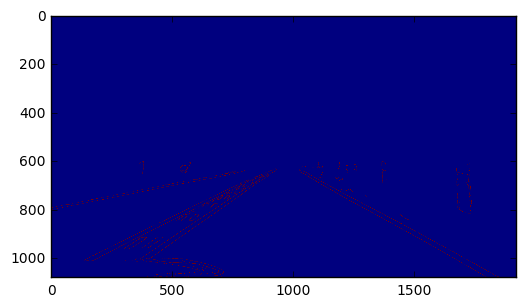



  0%|          | 1/721 [00:01<22:52,  1.91s/it]

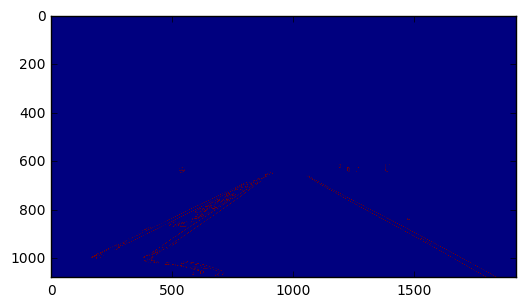

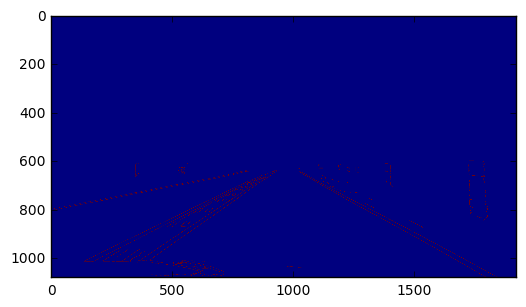



  0%|          | 2/721 [00:04<23:56,  2.00s/it]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "//anaconda/envs/selfdriving/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "//anaconda/envs/selfdriving/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "//anaconda/envs/selfdriving/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



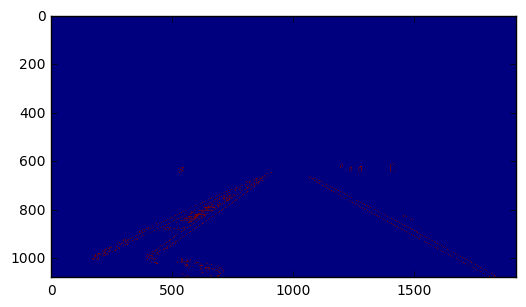

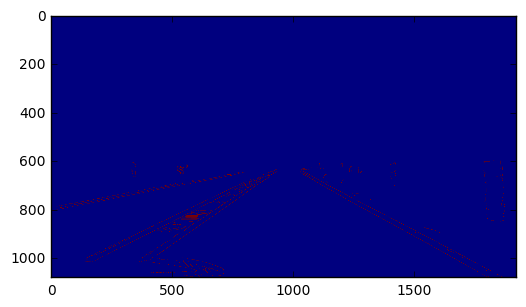

KeyboardInterrupt: 

In [50]:
glb_slope_left = glb_slope_right = glb_intercept_left = glb_intercept_right = 0.0

debug = True
challenge_output = 'ex3.mp4'
clip2 = VideoFileClip('extra_videos/Ex2.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))